In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from __future__ import print_function
import numpy as np
from tqdm import tqdm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import cm
plt.rcParams.update({'font.size': 14, 'lines.markersize' : 4})

from scipy.optimize import curve_fit
import sys, os
import time, datetime
from datetime import timedelta
import pandas as pd
sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/recon')
from recon_funcs import *
import h5py

In [24]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
my_cmap = cm.get_cmap('jet')
xr = np.linspace(0, 1, 2000)
my_cmap = my_cmap(xr)
my_cmap[0][-1] = 0
my_cmap = ListedColormap(my_cmap)

In [25]:
def make_MM(x0):
    xshift, yshift =  x0[8], x0[9] 

    # Coordinates that you want to Perspective Transform
    pts1 = np.float32([[0,0],\
                       [0,1024],\
                       [1024,0],\
                       [1024, 1024]])


    # Size of the Transformed Image
    pts2 = np.float32([[0+xshift-x0[0],0 + yshift-x0[1]],\
                       [0+xshift-x0[2],1024 + yshift-x0[3]],\
                       [1024+xshift-x0[4],0 + yshift-x0[5]],\
                       [1024+xshift-x0[6],1024 + yshift-x0[7]]])

    MM = cv2.getPerspectiveTransform(pts1,pts2)
    return MM

X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>120) & (rs<420)]=1
nmask = np.reshape(rebin(rebin(maskhm,4),4),[64**2,])


x,y, = 530,512
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-x)**2+(Y-y)**2)
mask=np.zeros((1024,1024))
mask[rs>1*48]=1

nmask = np.reshape(rebin(rebin(maskhm,4),4),[64**2,]) #rebin later
nnmask = (rebin(np.reshape(nmask, [64,64]))).flatten()
nnmask = rebin(rebin(maskhm,4),4)
#nnmask = (rebin(np.reshape(nmask, [64,64])*(inbg))).flatten()
nnmask[nnmask<0.5] = 0
nnmask[nnmask>=0.5] = 1

maskscale = np.zeros((1024,1024))
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskscale [(rs>120) & (rs<270)]=1

def make_quads(x0):
    quads=np.ones((1024,1024))
    quads[:512,:512]= x0[0]
    quads[:512,512:]= x0[1]
    quads[512:,:512]= x0[2]
    quads[512:,512:]= x0[3]
    return quads


In [26]:
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5') 

gasoff = np.load('/reg/d/psdm/tmo/tmox51020/results/paris/recon/gas_off_X510_112.npy')
inner_bg = np.load('/reg/d/psdm/tmo/tmox51020/results/paris/recon/inner_bg2.npy')
gasoff = np.load('/reg/d/psdm/tmo/tmox51020/results/paris/recon/gas_off_X510_112.npy')
inner_bg = np.load('/reg/d/psdm/tmo/tmox51020/results/paris/recon/inner_bg2.npy')

resid = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Jan/resid_bg_run110_2.npy') #np.load('/cds/home/p/paris/reconVMI_clean/resid_bg_mfgf10_unsat5.npy')
residold = np.load('/cds/home/p/paris/reconVMI_clean/resid_bg_mfgf10.npy')
#for background cal
ims_bg = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Aug/bg_for_cal.npy')
thresh = 32
gfsig = 0.985 #0.985 #0.875
 #int(sys.argv[7])
gfcart = 0.25 #applied to the simulated image to try to make it match the measured
mfcart = 1

In [45]:
runnum = 127
thresh = 32
MM = make_MM([-17.998,-2.74, 17.9, -17.39, 17.86, 8.52, -3.85, 17.9, 11.47, 47.86])
quads = cv2.warpPerspective(make_quads([0.92,0.96219608, 0.96632877, 0.99144247]),MM,(1024,1024))
#quads = make_quads([1,1,1,1])
#resid = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Jan/bg_run_127_Jul.npy')
resid = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Jan/bg_run_127_Mar.npy')
maskscale = np.zeros((1024,1024))
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskscale[(rs>130) & (rs<220)]=1
maskscale[(Y>26*16) & (Y<38*16)]=0

maskscale = np.zeros((1024,1024))
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskscale [(rs>120) & (rs<270)]=1

fanmask = np.ones((1024,1024))
# X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
# rs=np.sqrt((X-512)**2+(Y-512)**2)
# fanmask [(16*46.5<X) &(X<16*58) & (32*16<Y) & (Y<42*16)]=0

mfn = 25 
gfn = 15 
tt = np.array([4410497621974937433, 4410497621983194972, 4410497629998117213,
       4410497652173142369, 4410497694490265229, 4410497694998562628,
       4410497712137145557, 4410497712245542140, 4410497715882265975,
       4410497716165512669, 4410497720519069530, 4410497729084232225,
       4410497729576014546, 4410497737457767587, 4410497737474413737,
       4410497738016265580, 4410497746764798069, 4410497746773186680,
       4410497751068285408, 4410497759283616809, 4410497759292005420,
       4410497768307400597, 4410497780459610821, 4410497793378592521,
       4410497797940553937, 4410497806356032354, 4410497806847945747,
       4410497827798889054, 4410497836372440360, 4410497840600954488,
       4410497841325913981, 4410497853944478549, 4410497858481274132,
       4410497861892816190, 4410497862042893684, 4410497862626295366,
       4410497866279534279, 4410497866671308628, 4410497888563218162,
       4410497917844967344, 4410497917870002105, 4410497917878390716,
       4410497918261645382, 4410497926301864528, 4410497926593499833,
       4410497926660215505, 4410497926685250266, 4410497926893523749,
       4410497948019055023, 4410497948435733061, 4410497948694207138,
       4410497952164207329, 4410497952605920128, 4410497957059353889,
       4410498038427285378, 4410498042505853084, 4410498115919286577,
       4410498116060975460, 4410498133309134620, 4410498162843590708,
       4410498163410477312, 4410498167038943608, 4410498189040953661,
       4410498214496186683, 4410498235789228033, 4410498269884859105,
       4410498270485038009, 4410498274488632504, 4410498295690316637,
       4410498299960773820, 4410498338812352937, 4410498343241276225,
       4410498343816551440, 4410498377304663573, 4410498429399103419,
       4410498437422938559, 4410498437973179013, 4410498438264945390,
       4410498446638873968, 4410498446730493329, 4410498446863924673,
       4410498446872313284, 4410498450392251925, 4410498450984173290,
       4410498562621088619, 4410498584081771117, 4410498587843668757,
       4410498601455235154, 4410498652608053413, 4410498656670106041,
       4410498656936837657, 4410498670240122599, 4410498704187249041,
       4410498721010865840, 4410498751463088402, 4410498777110866261,
       4410498777285978516, 4410498777636203026, 4410498794217729754,
       4410498794234375904, 4410498806979162853, 4410498807112594197,
       4410498807587730368, 4410498820032362329, 4410498820199085973,
       4410498824069380196, 4410498858949870686, 4410498862686733565,
       4410498875481327892, 4410498875514620192, 4410498875589724475,
       4410498880076843752, 4410498880693668806, 4410498889167736428,
       4410498901978714761], dtype =np.uint64)


print(len(tt))
print(len(np.unique(tt)))

115
115


In [46]:
tt = tt[[  3,   7,  10,  12,  13,  18,  25,  33,  38,  39,  40,  45,  51, 59,  74,  75,  78,  79,  82,  86,  88,  89,  93, 101, 110, 113]]

In [1]:
cVMIs = []
rawish= []
detsum = []
maxim = []
cVMIsold = []
specs = []
unproc = []
gds = []
tmstmps = []

ds=ps.DataSource(exp = 'tmox51020', run= runnum, timestamps=tt)
#ds=ps.DataSource(exp = 'tmox51020', run= runnum, filter = lambda evt:evt.timestamp in tt)

run = next(ds.runs())

opal1 = run.Detector('tmo_opal1') # OPAL camera looking at the holey mirror
gmd = run.Detector("gmd") # gas intensity detector 
timing = run.Detector('timing') # this gives access to evr codes
ebeam = run.Detector("ebeam")
opalfzp = run.Detector('tmo_fzpopal') 



if hasattr(run, 'epicsinfo'):
    epics_strs = [item[0] for item in run.epicsinfo.keys()][1:] # first one is weird
    epics_detectors = [run.Detector(item) for item in epics_strs]    

for nevent, event in enumerate(run.events()):

    # data = {'epics_'+epic_str: epic_det(event) for epic_str, epic_det in zip(epics_strs, epics_detectors)}        
    # if any(type(val) not in [int, float] for val in data.values()):
    #     print("Bad EPICS: %d" % nevent)
    #     #Nbad += 1
    #     continue

    # fetch the information from the different events
    im_look=np.copy(opal1.raw.raw(event))  #opal1im_i=np.copy(opal1.raw.image(event)) #doesn't work since update
    im1=im_look

    ims = np.rot90(im1*mask)
    rawish.append(ims)
    detsum.append(np.sum(ims))
    #ims = cv2.warpPerspective(ims,MM,(1024,1024))
    gasoff = 0 #gasoff0#/np.mean(gasoff0)*np.mean(ims)
    ims = cv2.warpPerspective(ims-gasoff,MM,(1024,1024))*quads
    ims[ims<0] = 0
    ims2 = np.copy(ims)
    ims2 = mf(ims2, mfn)
    ims2 = gf(ims2, gfn)
    ims2= rebin(rebin(ims2,4),4)
    unproc.append(ims2)

    #resid_scale = resid/np.mean(resid[24:36,22:27])*np.mean(ims2[24:36,22:27])
    resid_scale = resid/np.mean(resid*rebin(rebin(maskscale,4),4))*np.mean(ims2*rebin(rebin(maskscale,4),4))
    #resid_test = resid/np.mean(resid*rebin(rebin(testmask,4),4))*np.mean(ims2*rebin(rebin(testmask,4),4))
    #residold_scale = residold/np.mean(residold*rebin(rebin(maskscale,4),4))*np.mean(ims2*rebin(rebin(maskscale,4),4))
    #ims2old = ims2 - residold_scale
    #testim = ims2 - resid_test
    maxim.append(np.max(ims2))
    ims2 = ims2 - resid_scale
    ims2 = gf(ims2,.25)
    #testim = gf(testim,.25)
    #ims2old = gf(ims2old,.25)
    #ims2 = rebin(ims2) #*inbg
    ims2 = ims2*rebin(rebin(maskhm*fanmask,4),4)*250/np.max(ims2)
    #testim = testim *rebin(rebin(maskhm,4),4)*250/np.max(testim)
    #ims2old = ims2old*rebin(rebin(maskhm,4),4)*250/np.max(ims2old)
    ims2[ims2<thresh] = 0
    #testim[testim<thresh] = 0
    #ims2old[ims2old<thresh] = 0
    cVMIs.append(ims2)
    #cVMIsold.append(ims2old)
    '''
    fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
    axs[0].pcolormesh(ims2, cmap = my_cmap)
    axs[0].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
    axs[1].pcolormesh(testim, cmap = my_cmap)
    axs[1].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
    plt.show()
    '''
    
    opalfz= np.copy(opalfzp.raw.image(event)) #np.copy(opal1.raw.image(event)) #np.copy(opal1.raw.raw(event))
    zps_data = opalfz
    zps_pixel = 100+np.argmax(np.sum(zps_data[100:900],axis=1))
    px_2d_width = 25 #spacing to cut the 2d image slice to store. Typically 50 pixel width. 25 on either side
    px_edge_width = 5 #spacing to integrate for the line out. 

    zps_2d = zps_data[zps_pixel-px_2d_width:zps_pixel+px_2d_width][:]
    zps = zps_data[zps_pixel-px_edge_width:zps_pixel+px_edge_width][:].mean(0)#
    zps_bg = zps_data[zps_pixel-px_2d_width:zps_pixel-px_2d_width+px_edge_width][:].mean(0)#
    zps = zps-zps_bg
    spec = np.squeeze(fastsmooth1(zps,10))
    spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[800:900])) 
    specs.append(spec)
    gd_i=gmd.raw.energy(event)
    gds.append(gd_i)
    tmstmps.append(event.timestamp)
    print(event.timestamp) 
    
print('fanmask')

NameError: name 'ps' is not defined

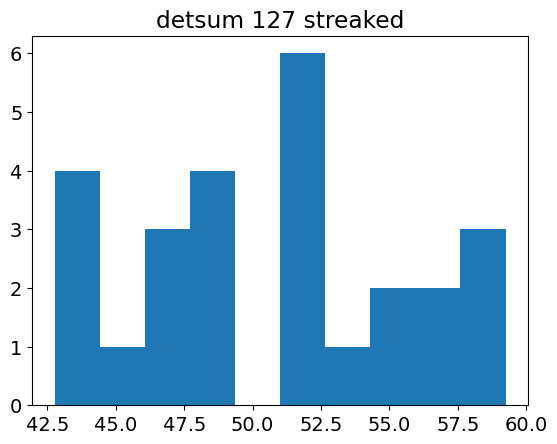

Text(0.5, 1.0, 'maxim 127 streaked')

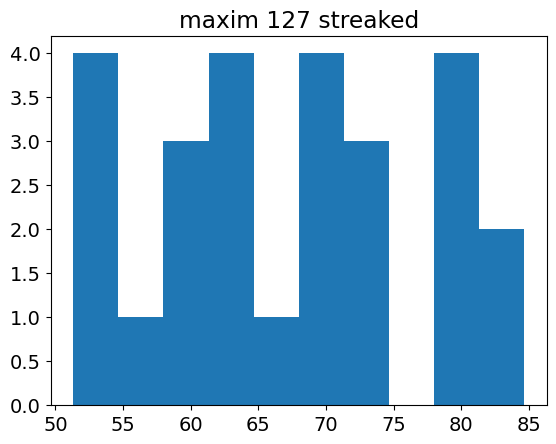

In [51]:
plt.hist(np.array(detsum)/1e6)
plt.title('detsum 127 streaked')
plt.show()
plt.hist(maxim)
plt.title('maxim 127 streaked')

In [52]:
resid2 = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Jan/bg_run_127_Jul26.npy')

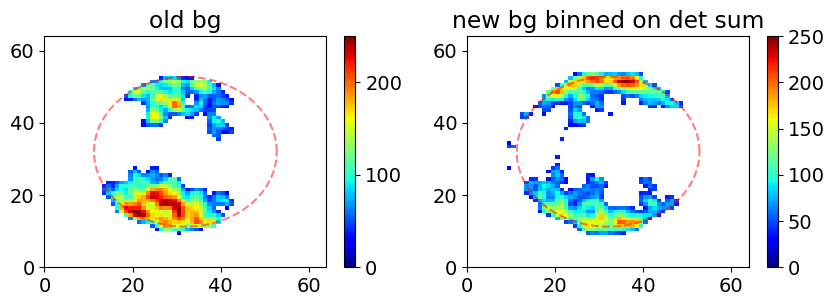

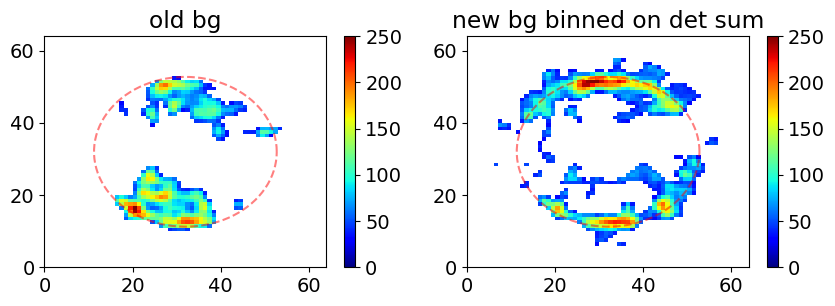

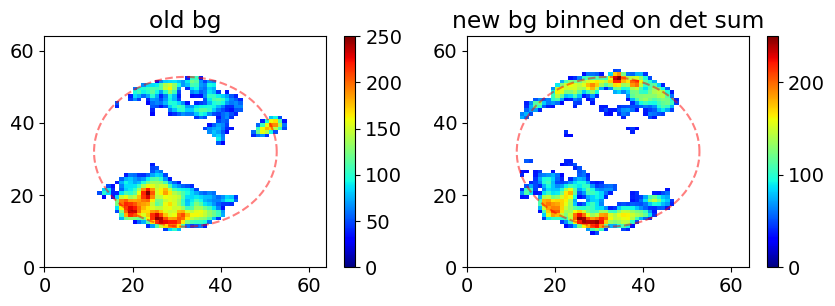

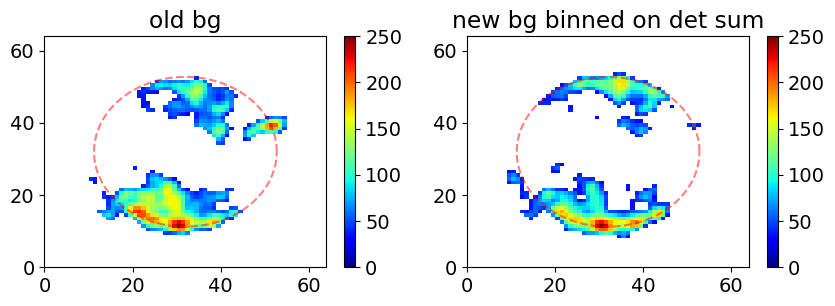

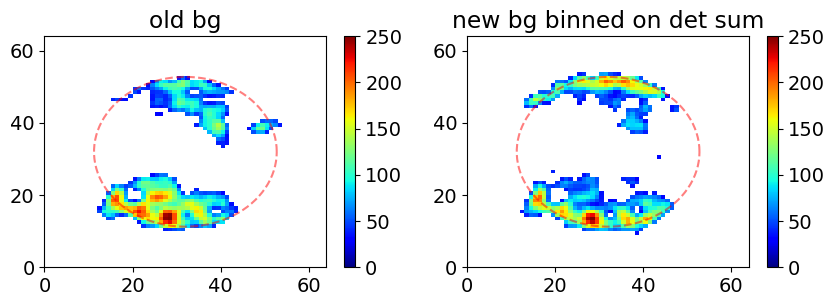

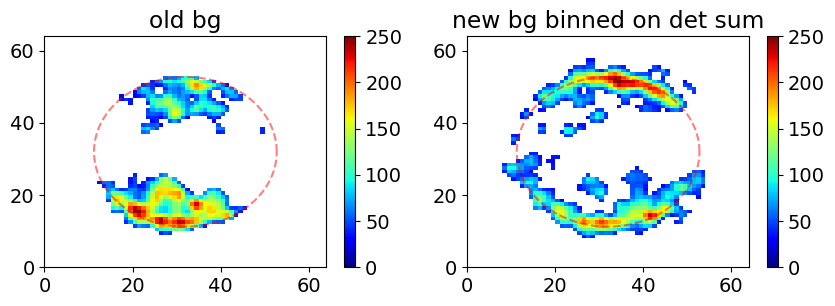

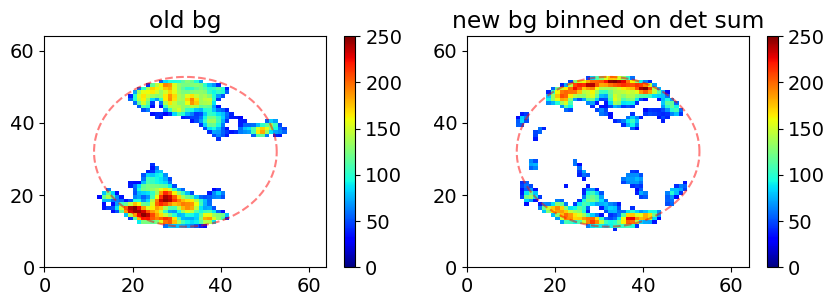

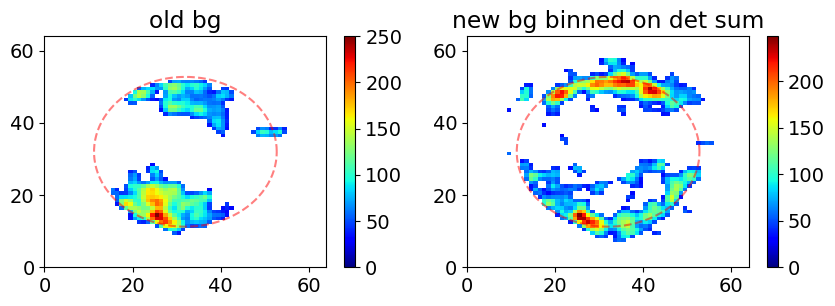

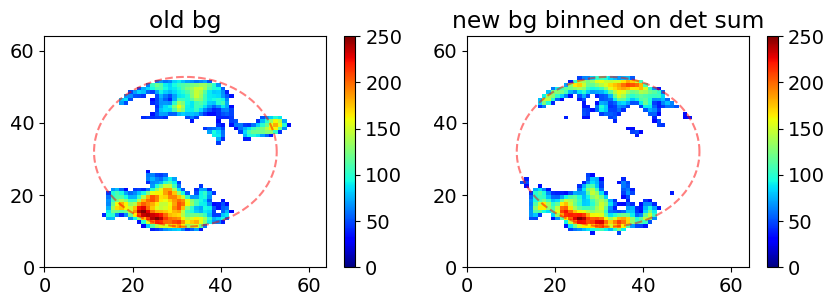

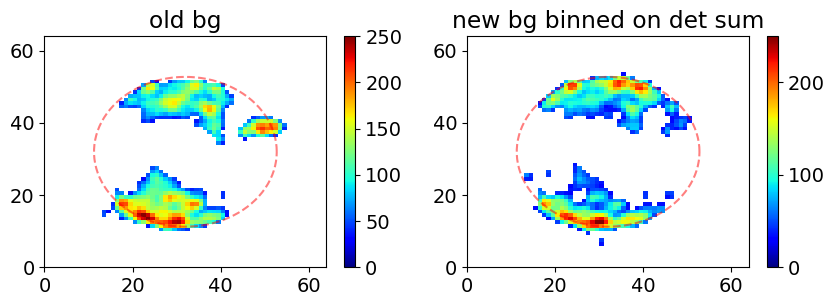

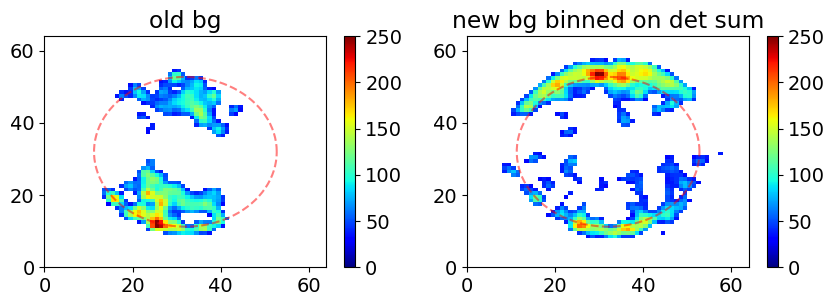

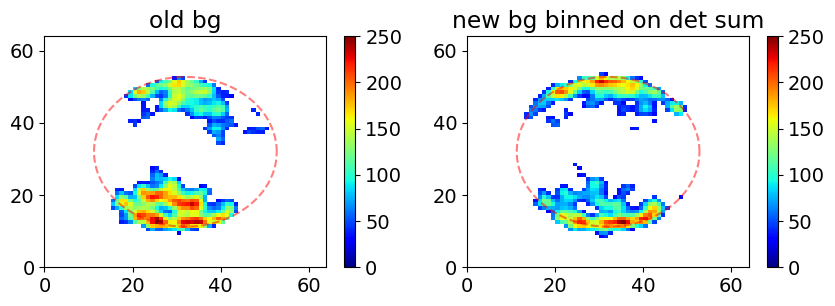

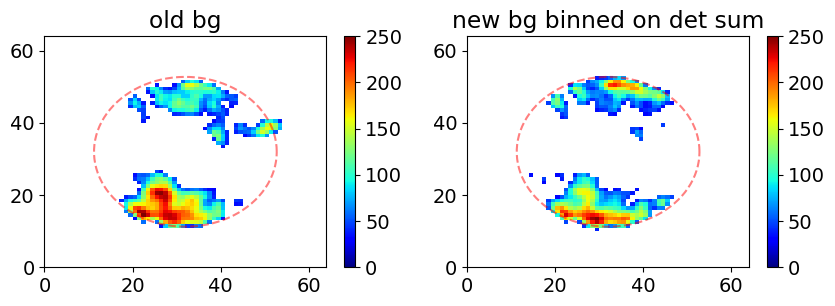

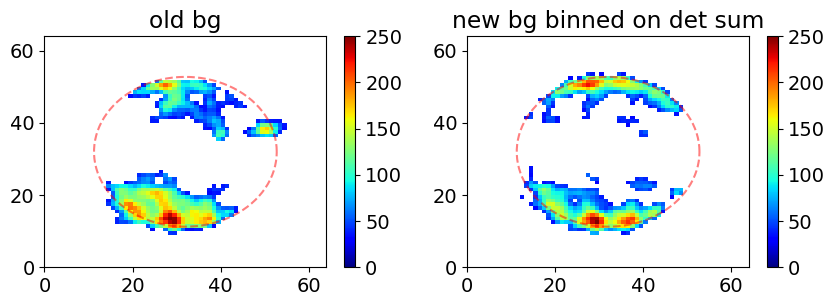

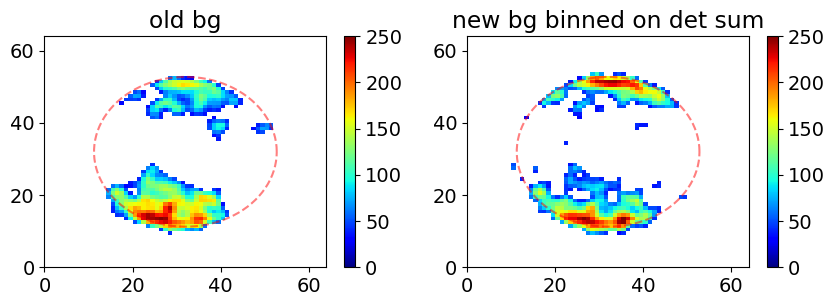

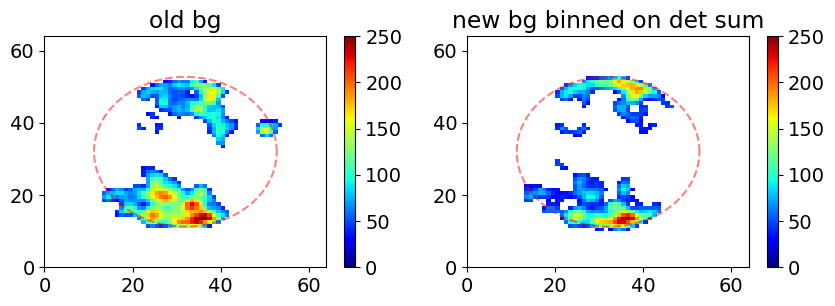

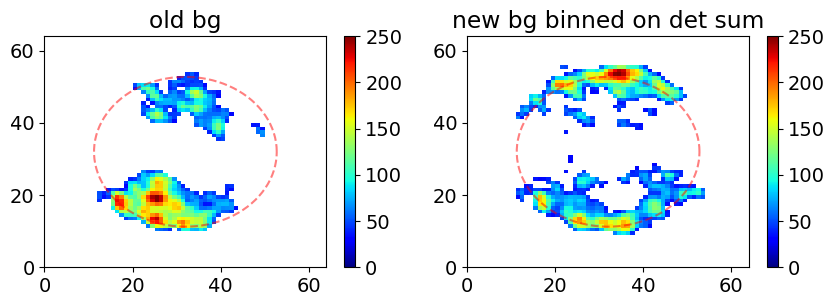

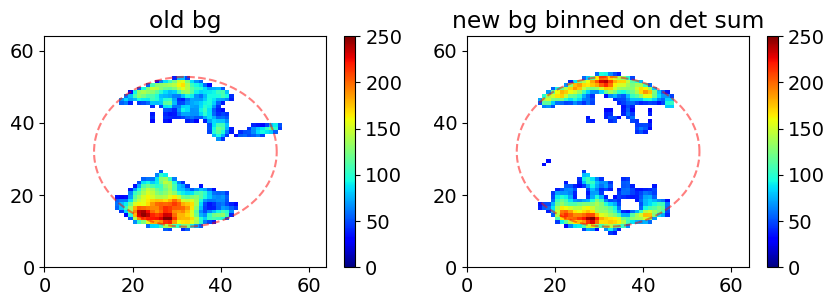

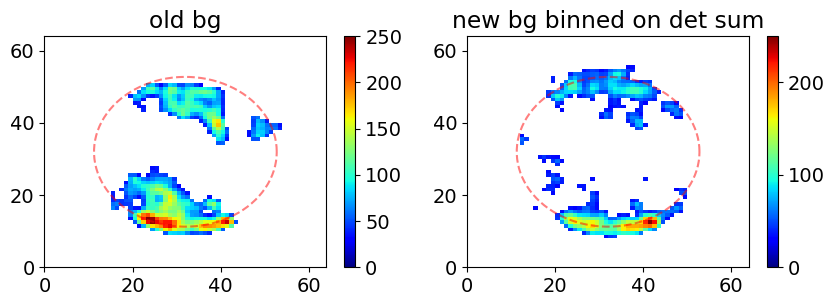

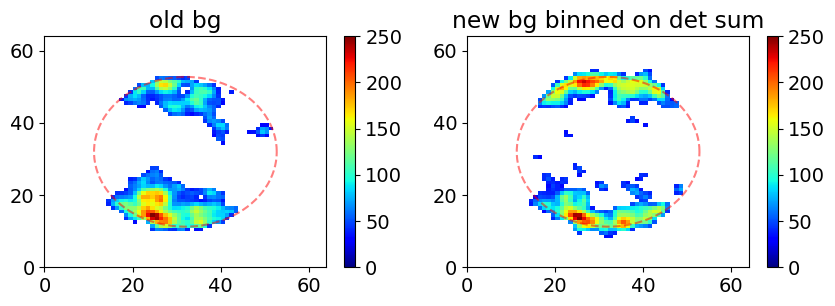

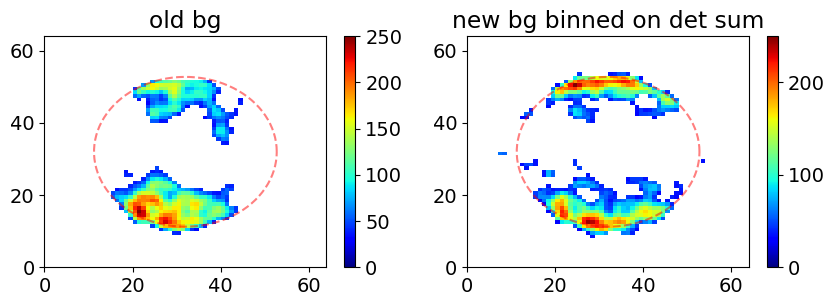

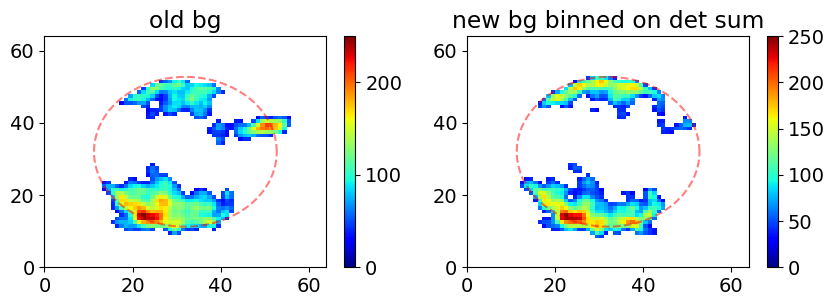

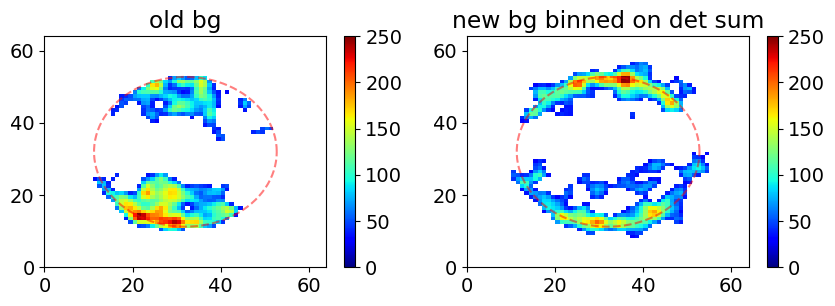

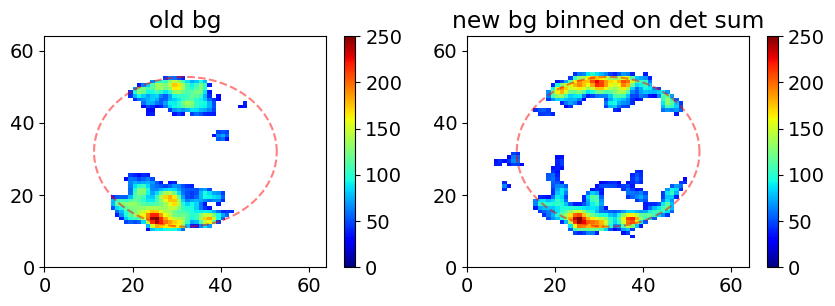

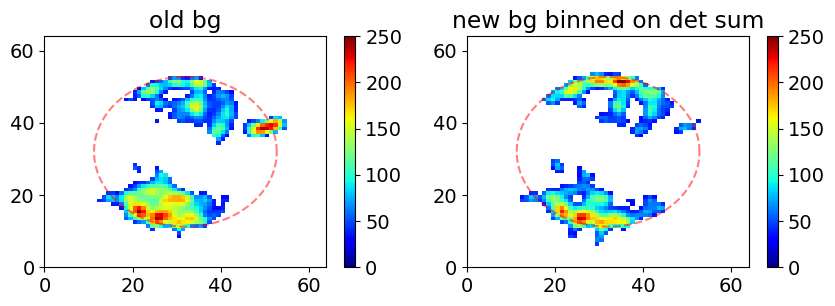

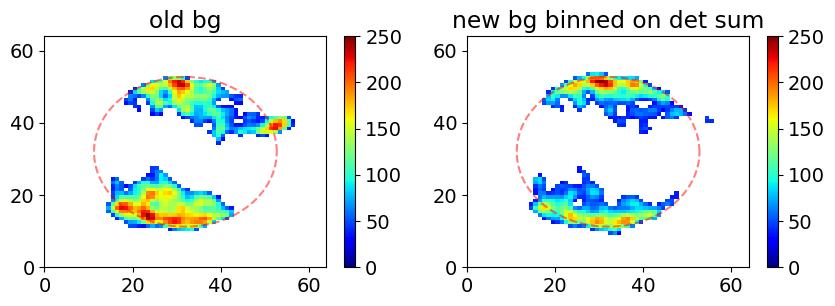

In [53]:
phi_rad = np.linspace(0,360,100)*np.pi/180

for i in range(len(specs)):
    fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,3))
    c = cVMIs[i]
    c[c<0] = 0
    cVMIs[i] = c
    p =axs[0].pcolormesh(c, cmap = my_cmap)
    axs[0].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
    plt.colorbar(p,ax = axs[0])
    #axs[0].set_title('detsum %1.2fe6, max %1.2f' %(detsum[i]/1e6,maxim[i]))
    axs[0].set_title('old bg')

    resid_scale = resid2/np.mean(resid2*rebin(rebin(maskscale,4),4))*np.mean(unproc[i]*rebin(rebin(maskscale,4),4))
    ims2 = unproc[i] - resid_scale
    ims2 = gf(ims2,.25)
    ims2 = ims2*rebin(rebin(maskhm*fanmask,4),4)*250/np.max(ims2)

    ims2[ims2<thresh] = 0
    p =axs[1].pcolormesh(ims2, cmap = my_cmap)
    axs[1].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
    plt.colorbar(p,ax = axs[1])
    axs[1].set_title('new bg binned on det sum')
    plt.show()

In [37]:
#Check unstreaked
exp =  "tmox51020" #"tmoly9120" #'tmox45719'
gas_jet = 1
print_at = 20
runnum = 127 #112 #106 #93 #76 #73
gmd_min = 0.12 #0.15
gmd_max = 25

In [42]:
nn = 0
ds = ps.DataSource(exp=exp, run=runnum)
run = next(ds.runs())

if hasattr(run, 'epicsinfo'):
    epics_strs = [item[0] for item in run.epicsinfo.keys()][1:] # first one is weird
    epics_detectors = [run.Detector(item) for item in epics_strs]    


# specify detectors here
opal1 = run.Detector('tmo_opal1') # OPAL camera looking at the holey mirror
gmd = run.Detector("gmd") # gas intensity detector 
xgmd = run.Detector("xgmd") # gas intensity detector 
timing = run.Detector('timing') # this gives access to evr codes
ebeam = run.Detector("ebeam")
opalfzp = run.Detector('tmo_fzpopal') 



ims_bg = [] # initialize the list of example images here
GDs_bg = []
xGDs_bg = []
specs = []
jet_timing_bg = []


for nevent, event in enumerate(run.events()): # loop over events (shots) in the run

    # fetch the information from the different events
    opal1im_i=np.copy(opal1.raw.raw(event))
    #opal1im_i=np.copy(opal1.raw.image(event)) #doesn't work since update
    gd_i=gmd.raw.energy(event)
    xgd_i=xgmd.raw.energy(event)
    evr=timing.raw.eventcodes(event)
    L3 = ebeam.raw.ebeamL3Energy(event)

    # identify relevant event codes
    gas=evr[70] # did the gas jet fire
    ir_timed=evr[67] # was the ir laser timed
    ir_misttimed=evr[68] # was the ir laser mis-timed

    
    #if opal1im_i is None or gd_i is None or gd_i<gmd_min or (gas != gas_jet): continue
    if opal1im_i is None or gd_i is None or gd_i>gmd_max or gd_i<gmd_min or (gas != gas_jet): continue
    #if np.sum(opal1im_i*mask) < 37e6: continue
    #if np.sum(opal1im_i*mask) > 40e6: continue
    if np.sum(opal1im_i*mask) < 42e6: continue
    #if event.timestamp < 4410498451167543084: continue
    #if np.sum(opal1im_i) < 46e6: continue
    
    data = {'epics_'+epic_str: epic_det(event) for epic_str, epic_det in zip(epics_strs, epics_detectors)}        
    if any(type(val) not in [int, float] for val in data.values()):
        print("Bad EPICS: %d" % nevent)
        #Nbad += 1
        continue
        
        
    if ir_misttimed:
        ims = np.rot90(opal1im_i*mask)
        #ims = ims/np.sum(ims)
        #ims = cv2.warpPerspective(ims,MM,(1024,1024))
        #ims_bg.append(ims[100:900,100:900])
        ims_bg.append(ims)
        GDs_bg.append(gd_i)
        xGDs_bg.append(xgd_i)
        jet_timing_bg.append(data['epics_evr_ch0_delay'])
        
        opalfz= np.copy(opalfzp.raw.image(event)) #np.copy(opal1.raw.image(event)) #np.copy(opal1.raw.raw(event))
        zps_data = opalfz
        zps_pixel = 100+np.argmax(np.sum(zps_data[100:900],axis=1))
        px_2d_width = 25 #spacing to cut the 2d image slice to store. Typically 50 pixel width. 25 on either side
        px_edge_width = 5 #spacing to integrate for the line out. 

        zps_2d = zps_data[zps_pixel-px_2d_width:zps_pixel+px_2d_width][:]
        zps = zps_data[zps_pixel-px_edge_width:zps_pixel+px_edge_width][:].mean(0)#
        zps_bg = zps_data[zps_pixel-px_2d_width:zps_pixel-px_2d_width+px_edge_width][:].mean(0)#
        zps = zps-zps_bg
        spec = np.squeeze(fastsmooth1(zps,10))
        spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[800:900])) 
        specs.append(spec)
        
        nn +=1
        
        
    

    if nn%20 == 0:
        print('gathered: %1.0f' %nn)
        
    if len(ims_bg) > 300:
        break
print(event.datetime())   

gathered: 20
gathered: 20
gathered: 40
gathered: 40


KeyboardInterrupt: 

In [43]:
imsM = [cv2.warpPerspective(ii,MM,(1024,1024)) for ii in ims_bg]
imsM = np.array(imsM)

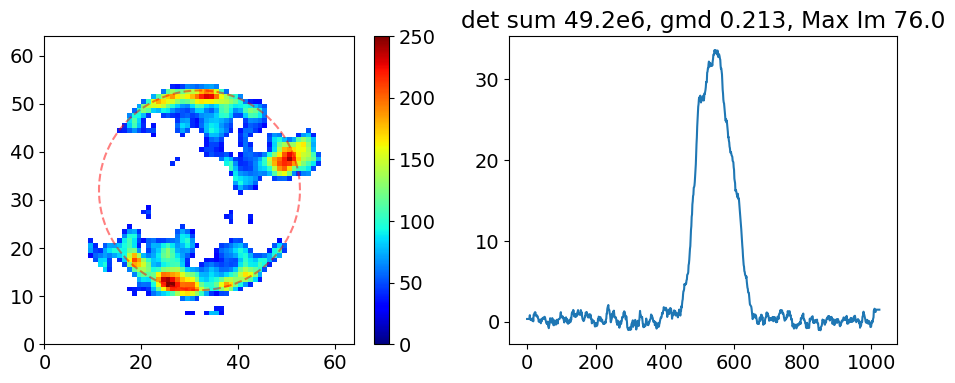

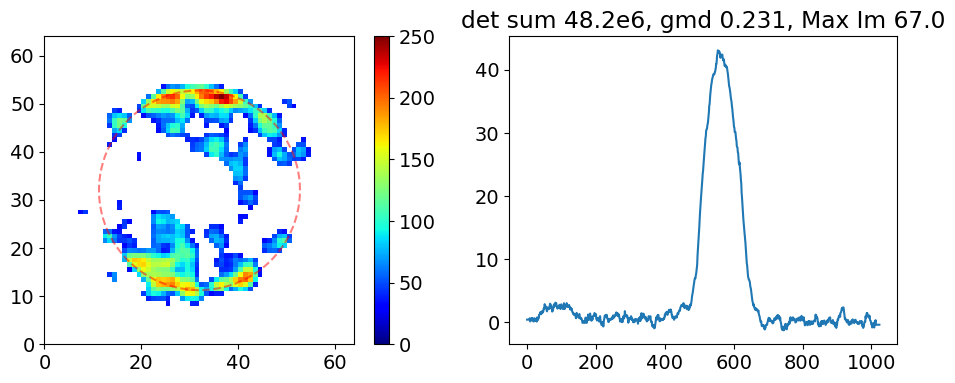

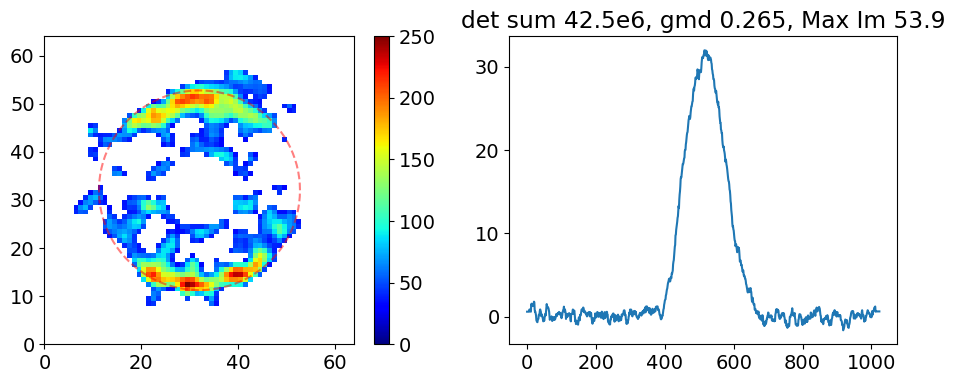

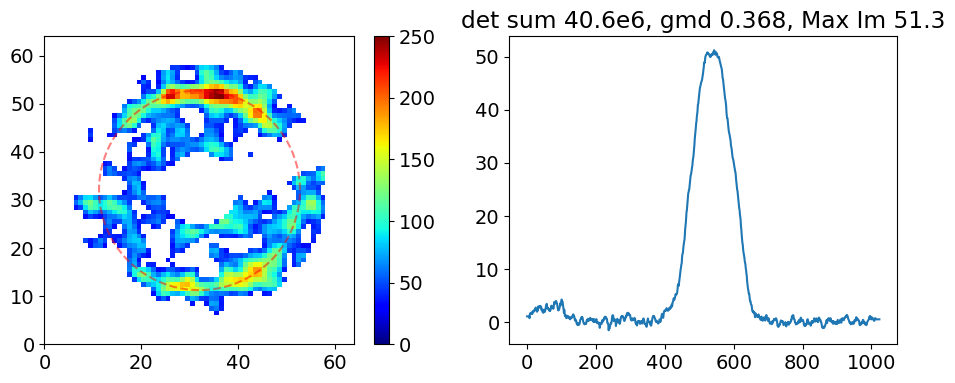

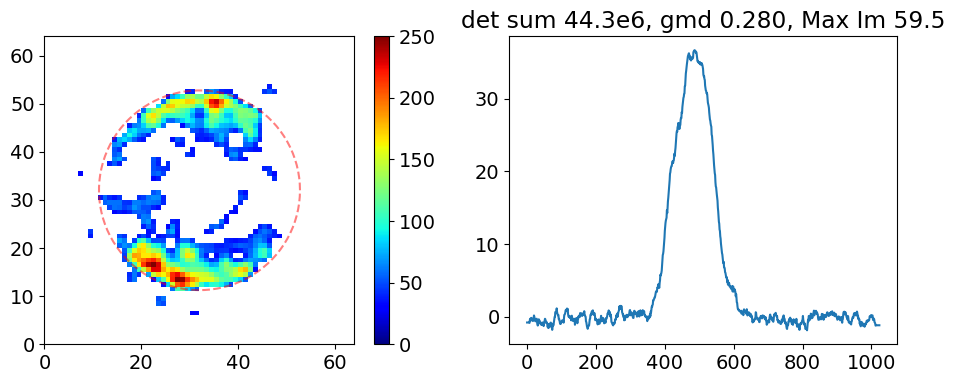

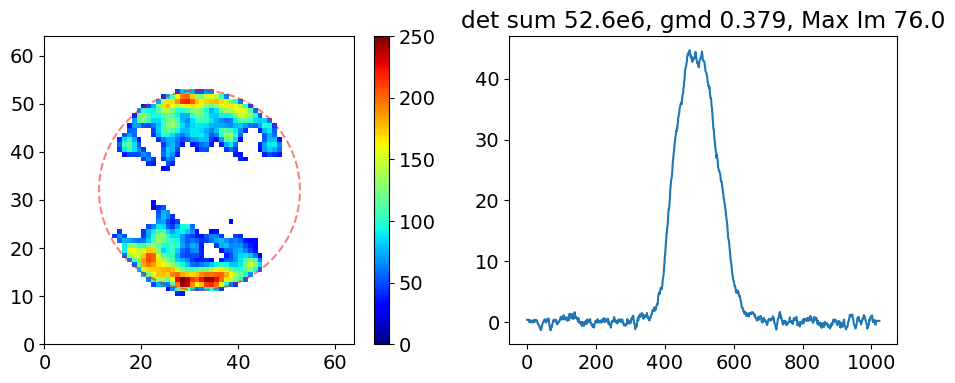

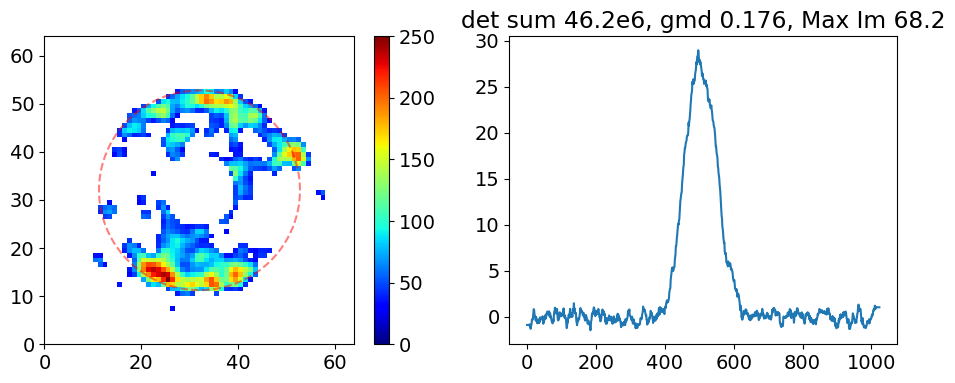

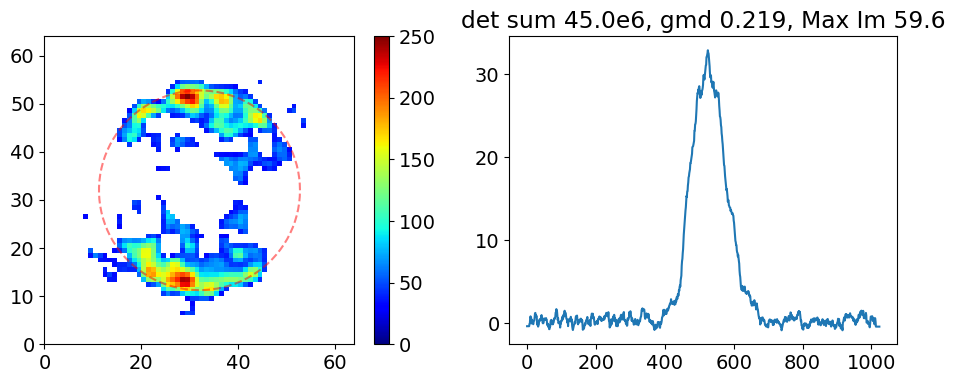

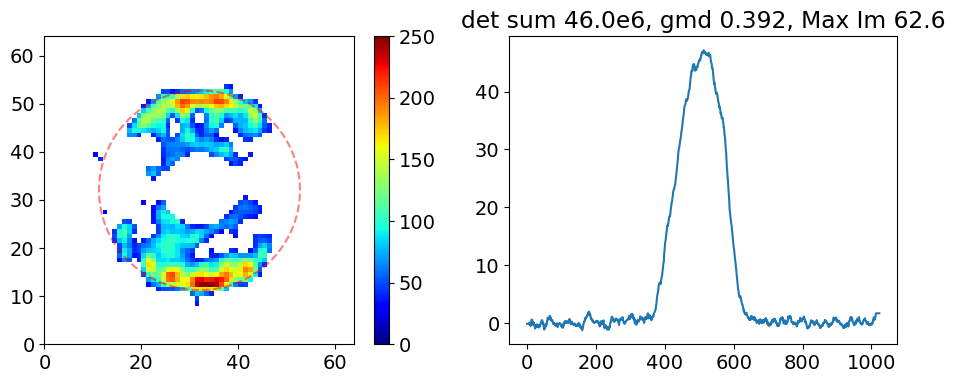

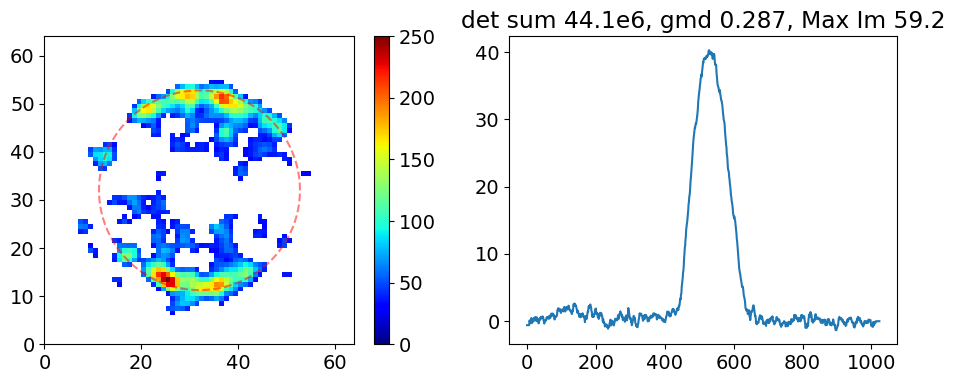

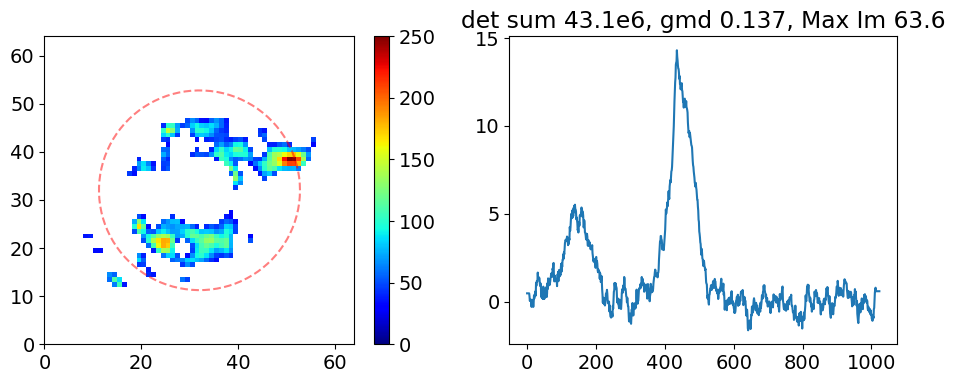

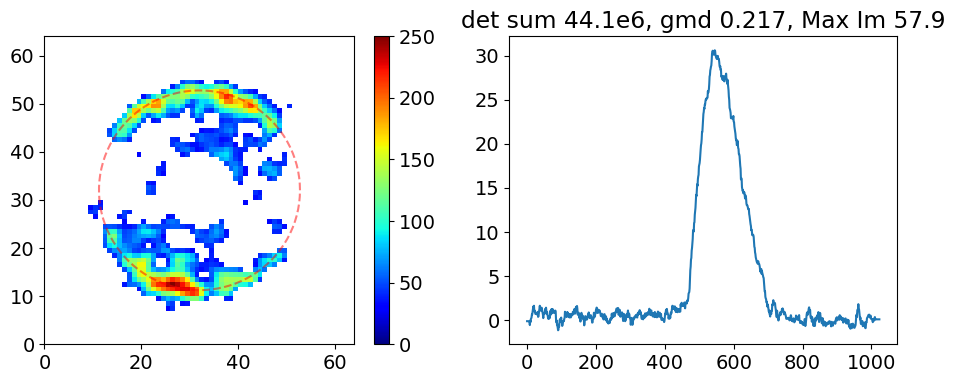

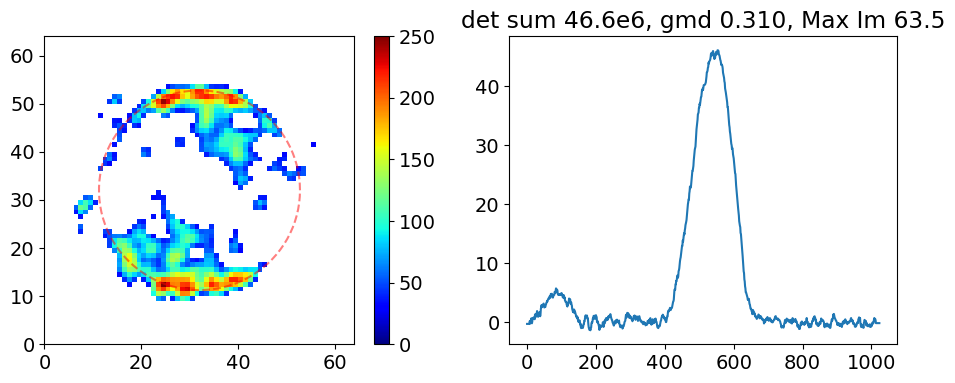

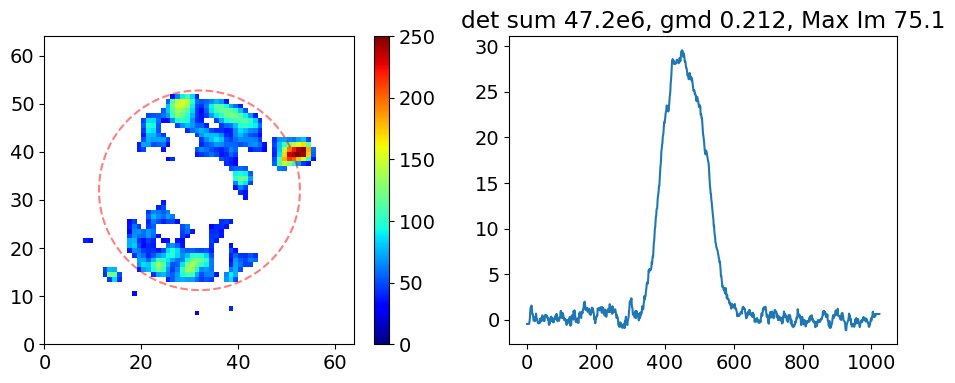

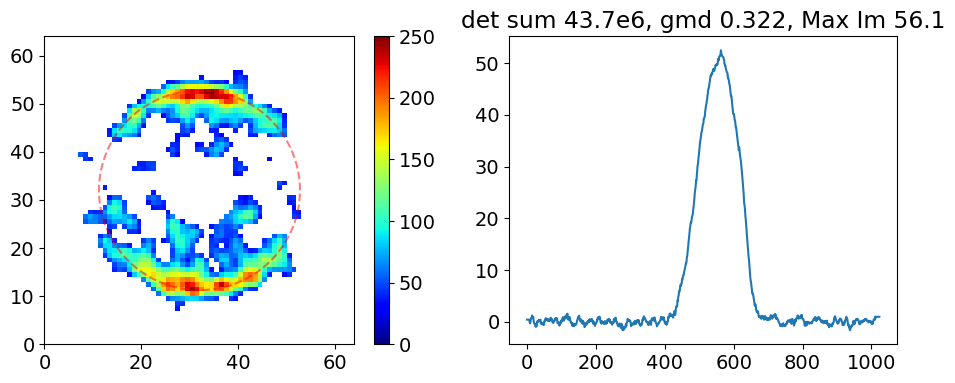

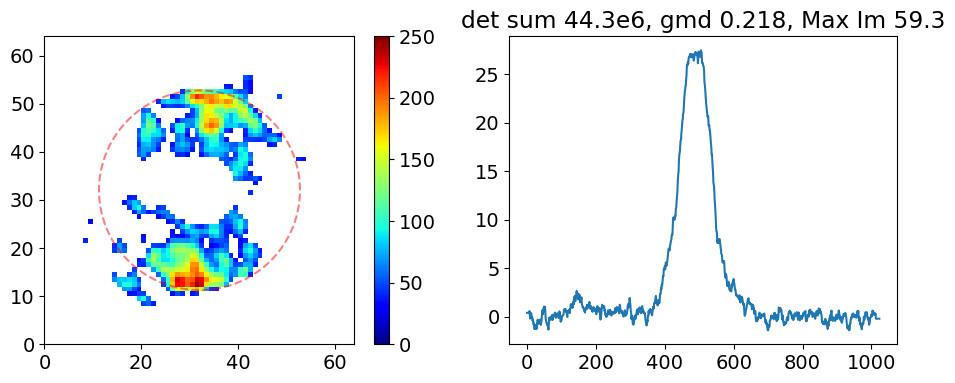

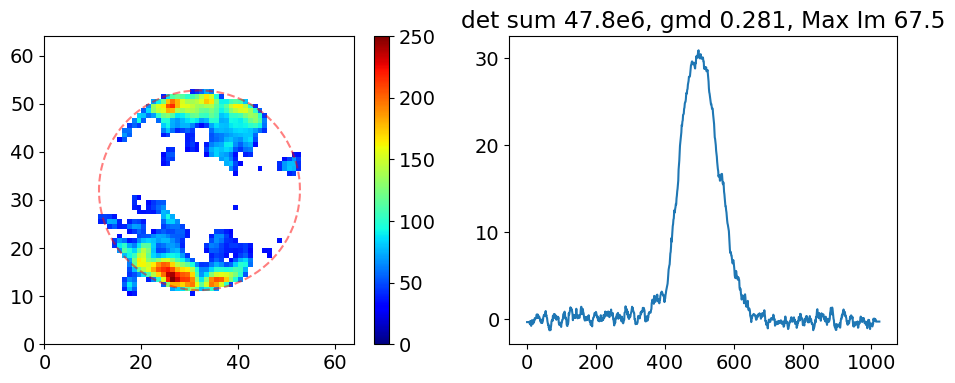

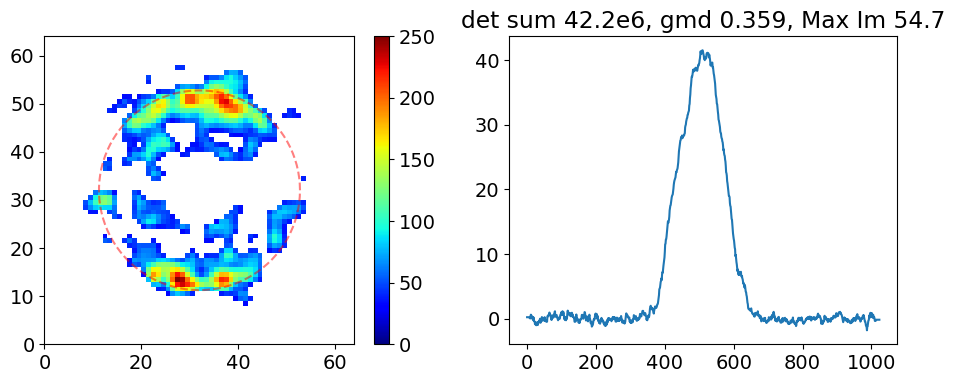

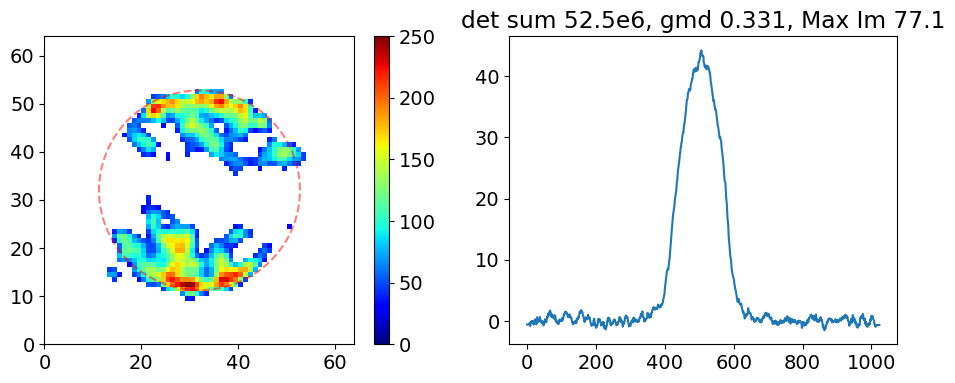

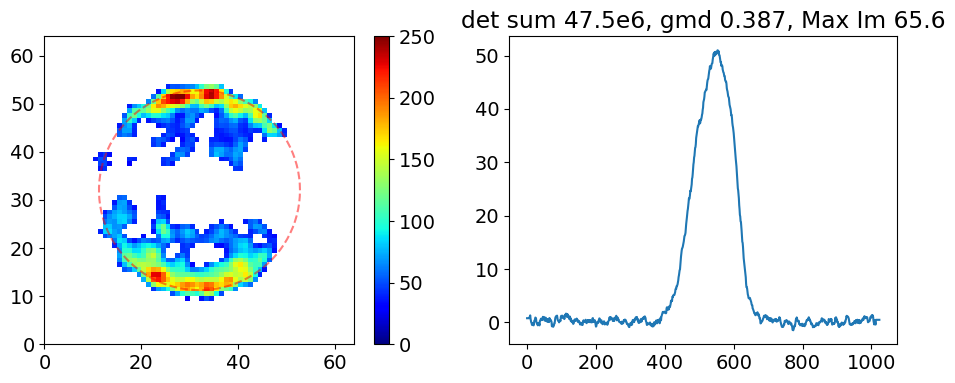

In [44]:
for i in range(20):
    ims2 = imsM[i]*quads
    ims2 = mf(ims2, mfn)
    ims2 = gf(ims2, gfn)
    ims2= rebin(rebin(ims2,4),4)

    m = np.max(ims2) #when making dipole bg
    resid_scale = resid2/np.mean(resid2*rebin(rebin(maskscale,4),4))*np.mean(ims2*rebin(rebin(maskscale,4),4))

    ims2 = ims2 - resid_scale*0.98
    ims2 = gf(ims2,.25)
   
    
    ims2 = ims2*rebin(rebin(maskhm,4),4)*250/np.max(ims2)
    ims2[ims2<thresh] = 0
    fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (11,4))
    p = axs[0].pcolormesh(ims2, cmap = my_cmap)
    plt.colorbar(p, ax = axs[0])
    axs[0].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
    axs[1].plot(specs[i])
    plt.title('det sum %1.1fe6, gmd %1.3f, Max Im %1.1f' %(np.sum(imsM[i]/1e6), GDs_bg[i], m))
    #plt.colorbar()
    plt.show()